# **Data Quest Round 2 - Bank Data - User Default Probability Prediction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Loading and Understanding the Data

In [5]:
# Load data
train_data = pd.read_csv('train_data/train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Explore data
print(train_data.head())
print(train_data.info())
print(train_data.describe())


   account_number  bad_flag  onus_attribute_1  transaction_attribute_1  \
0           47642         0               NaN                      NaN   
1           95032         0          108000.0                      0.0   
2           40510         0           61000.0                      0.0   
3           51692         0          469000.0                      0.0   
4           27459         0          152000.0                      0.0   

   transaction_attribute_2  transaction_attribute_3  transaction_attribute_4  \
0                      NaN                      NaN                      NaN   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   transaction_attribute_5  transaction_attribute_6  transaction_attribute

# Insight : Feature Reduction is absolutely Necessary due to the large size of the dataset

Steps taken:

1.   Dropping non informative columns.
2.   Dropping majorly(>50%) empty columns.
3.   Dropping highly correlated features. (Indicate redundant data)



In [7]:
# Drop non-informative columns
train_data = train_data.drop(columns=["account_number"])  # Remove ID column

# Handle missing values
missing_percent = train_data.isnull().sum() / len(train_data) * 100
high_missing_cols = missing_percent[missing_percent > 50].index  # Columns with >50% missing
train_data = train_data.drop(columns=high_missing_cols)


In [15]:
# Correlation Heatmap (Checking Redundancy)

corr_matrix = train_data.corr()

# Drop highly correlated features (Threshold = 0.85)
corr_threshold = 0.85
  # corr_matrix = train_data.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]
train_data = train_data.drop(columns=high_corr_features)

# Identify top features using XGBoost
target = 'bad_flag'  # Define target variable
X = train_data.drop(columns=[target])  # Exclude target for feature selection
y = train_data[target]

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Keep top 50 features + target
selected_features = feature_importance["Feature"].iloc[:50].values
selected_features = list(selected_features) + [target]  # Ensure 'bad_flag' remains

train_data = train_data[selected_features]  # Keep only top features + target

print("Final dataset shape after feature selection:", train_data.shape)

C:\Users\jaanh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:07:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final dataset shape after feature selection: (77444, 51)


# Insight : Dataset features have been reduced but selected features still have null values.

# **Handling missing Values in Selected Features**


1.   Use histogram to find data distribution
2.   Replace null values with features as required.

        skewed distribution - median
        
        normal distribution - mean



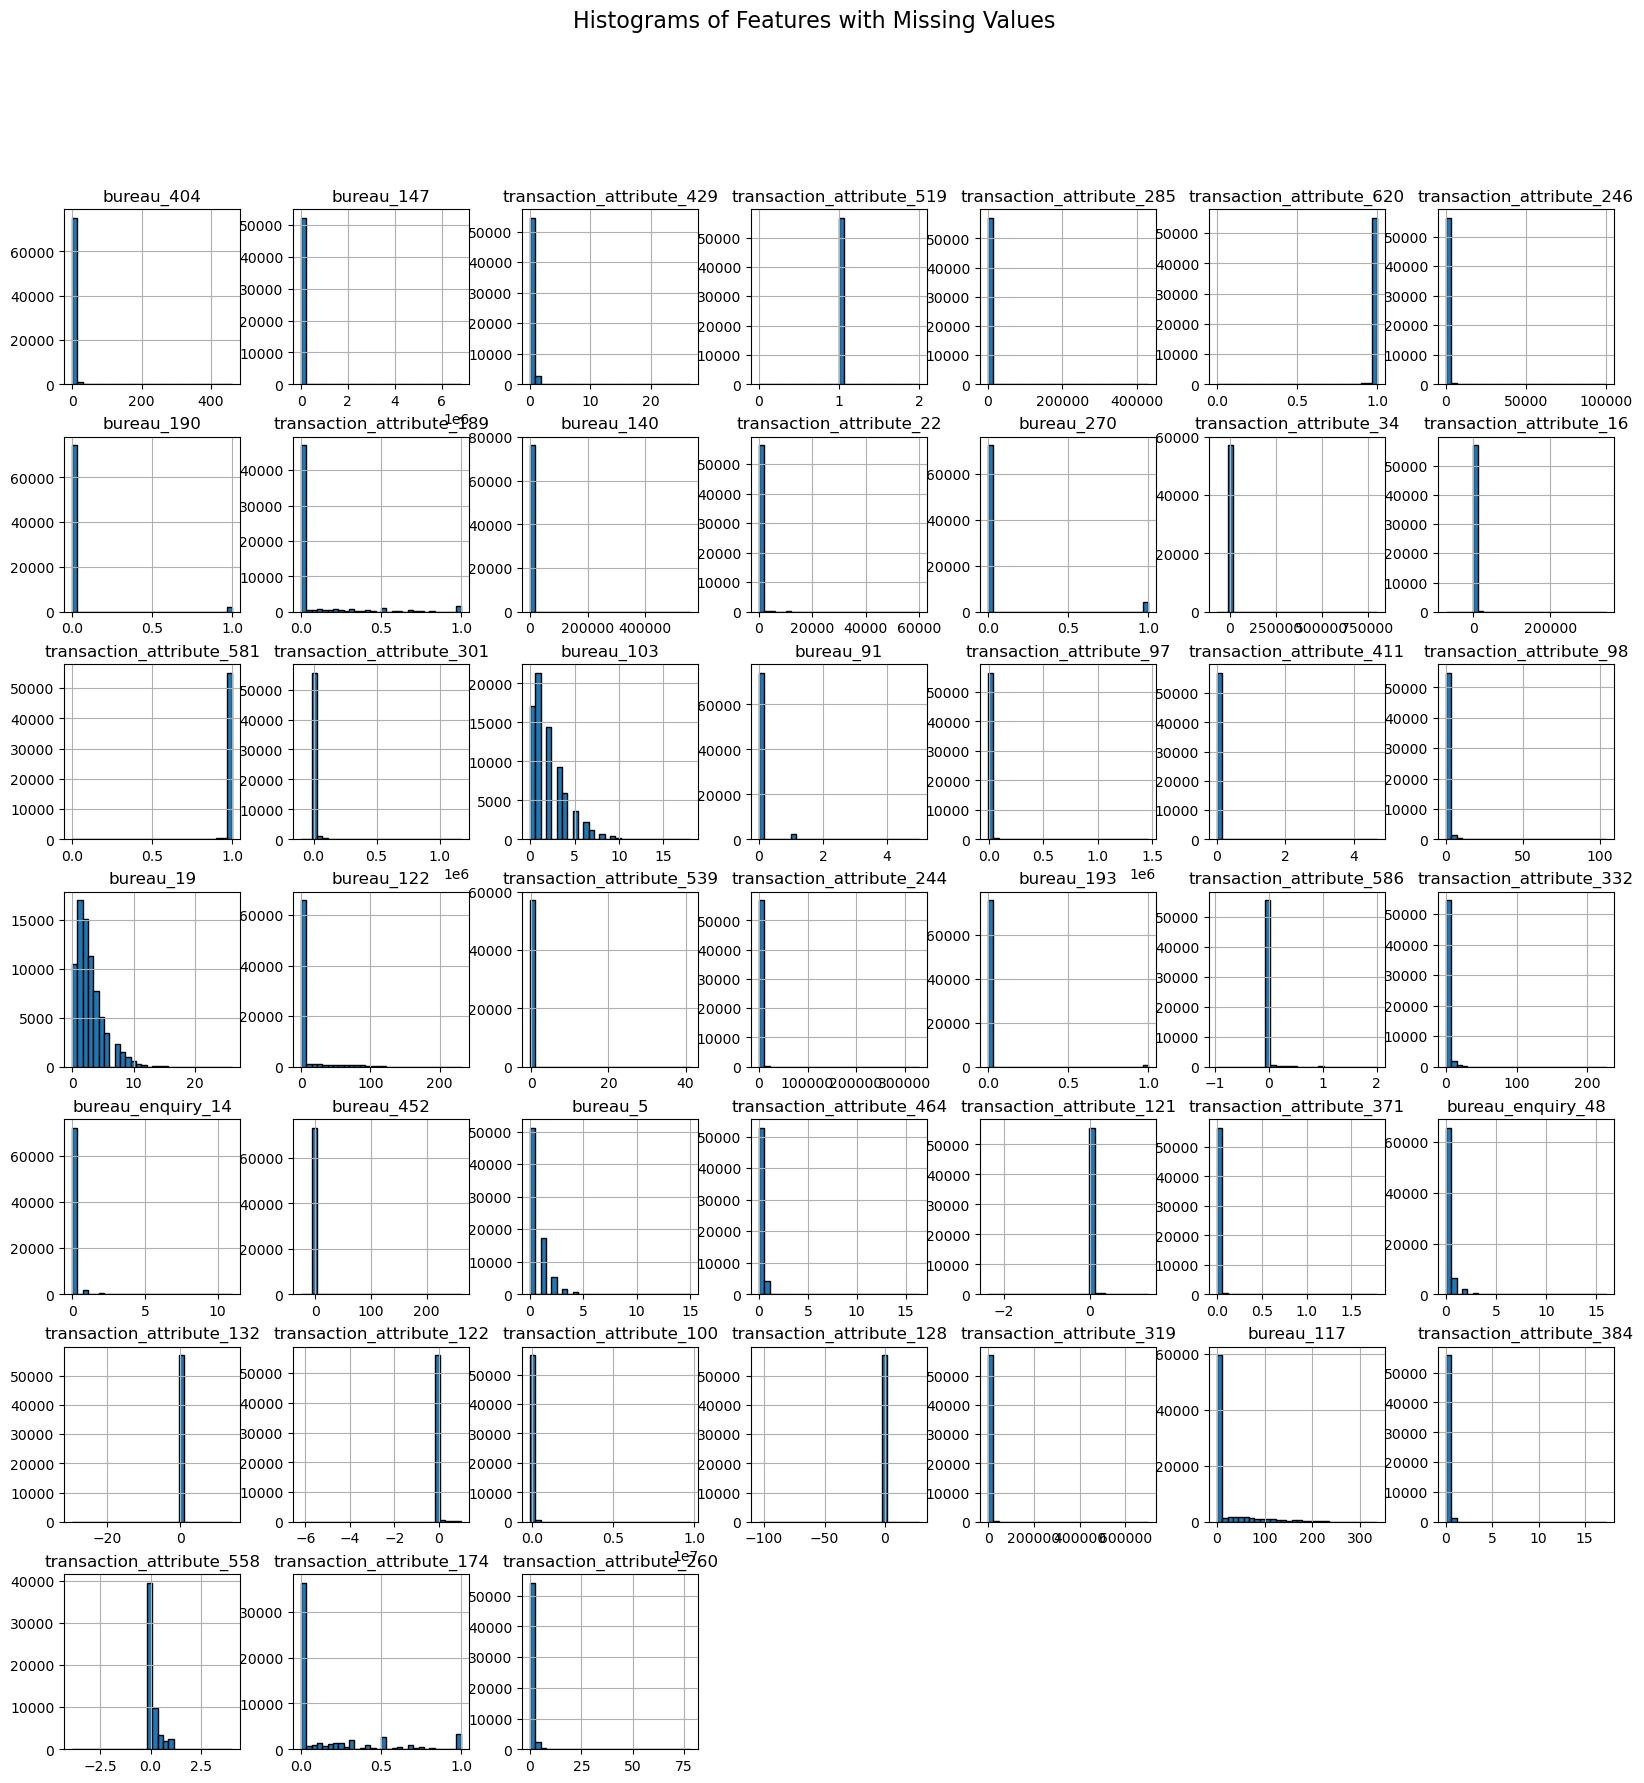

Filled missing values in 'bureau_404' using Median (Skewed Distribution).
Filled missing values in 'bureau_147' using Median (Skewed Distribution).
Filled missing values in 'transaction_attribute_429' using Median (Skewed Distribution).
Filled missing values in 'transaction_attribute_519' using Median (Skewed Distribution).
Filled missing values in 'transaction_attribute_285' using Median (Skewed Distribution).
Filled missing values in 'transaction_attribute_620' using Median (Skewed Distribution).
Filled missing values in 'transaction_attribute_246' using Median (Skewed Distribution).
Filled missing values in 'bureau_190' using Median (Skewed Distribution).
Filled missing values in 'transaction_attribute_189' using Median (Skewed Distribution).
Filled missing values in 'bureau_140' using Median (Skewed Distribution).
Filled missing values in 'transaction_attribute_22' using Median (Skewed Distribution).
Filled missing values in 'bureau_270' using Median (Skewed Distribution).
Filled m

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

def handle_missing_values(df, threshold=50, plot_histograms=False):

    df = df.copy()  # Avoid modifying original data
    missing_cols = df.columns[df.isnull().sum() > 0]  # Columns with NaNs

    # Plot histograms if enabled
    if plot_histograms:
        df[missing_cols].hist(figsize=(20, 20), bins=30, edgecolor='black')
        plt.suptitle("Histograms of Features with Missing Values", fontsize=16)
        plt.show()

    # Handle remaining missing values
    for col in df.columns[df.isnull().sum() > 0]:  # Columns still with NaN

    # Numerical column
          skewness = df[col].dropna().skew()  # Check skewness
          if abs(skewness) < 0.5:  # Normal distribution (Bell Curve)
              imputer = SimpleImputer(strategy="mean")
              print(f"Filled missing values in '{col}' using Mean (Normal Distribution).")
          else:  # Skewed distribution
              imputer = SimpleImputer(strategy="median")
              print(f"Filled missing values in '{col}' using Median (Skewed Distribution).")

          df[col] = imputer.fit_transform(df[[col]])

    return df


cleaned_data = handle_missing_values(train_data, threshold=50, plot_histograms=True)

# Check results
print(cleaned_data.isnull().sum())

In [17]:
print(train_data.columns)

Index(['onus_attribute_26', 'onus_attribute_29', 'bureau_404', 'bureau_147',
       'transaction_attribute_429', 'transaction_attribute_519',
       'onus_attribute_31', 'transaction_attribute_285',
       'transaction_attribute_620', 'transaction_attribute_246', 'bureau_190',
       'transaction_attribute_189', 'bureau_140', 'transaction_attribute_22',
       'bureau_270', 'transaction_attribute_34', 'transaction_attribute_16',
       'transaction_attribute_581', 'transaction_attribute_301', 'bureau_103',
       'bureau_91', 'transaction_attribute_97', 'transaction_attribute_411',
       'transaction_attribute_98', 'onus_attribute_34', 'bureau_19',
       'bureau_122', 'onus_attribute_2', 'transaction_attribute_539',
       'transaction_attribute_244', 'bureau_193', 'transaction_attribute_586',
       'transaction_attribute_332', 'bureau_enquiry_14', 'bureau_452',
       'bureau_5', 'transaction_attribute_464', 'transaction_attribute_121',
       'transaction_attribute_371', 'bureau_e

# Balancing the Dataset

In [20]:
train_data = cleaned_data

In [22]:
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

# Count instances in each class
class_counts = train_data['bad_flag'].value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

print(class_counts)

bad_flag
0    76342
1     1102
Name: count, dtype: int64


# Insight : Data is highly skewed with more values for bad_flag = 0 compared to bad_flag = 1. We need to balance the dataset to prevent biased results.

Use oversampling of minority class instead of undersampling of majority class to prevent information loss.

In [24]:
# Define oversampling ratio (increase the minority class)
ros = RandomOverSampler(sampling_strategy=1.0, random_state=42)  # Make both classes equal

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(train_data[selected_features], train_data['bad_flag'])

# Convert back to DataFrame
oversampled_data = pd.DataFrame(X_resampled, columns=selected_features)
oversampled_data['bad_flag'] = y_resampled  # Add target column back

print("Final oversampled dataset shape:", oversampled_data.shape)

Final oversampled dataset shape: (152684, 51)


Dataset is now balanced.

# Model Selection and Training for Probability Prediction

In [ ]:
!pip install imbalanced-learn


In [27]:
selected_features = [col for col in train_data.columns if col != 'bad_flag']


In [29]:
# Count instances in each class
class_counts = oversampled_data['bad_flag'].value_counts()
print(class_counts)

bad_flag
0    76342
1    76342
Name: count, dtype: int64


In [47]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

# Define Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize list to store results
auc_scores = []

# Loop through K-Fold splits
for train_index, valid_index in kf.split(oversampled_data[selected_features], oversampled_data['bad_flag']):
    X_train, X_valid = oversampled_data[selected_features].iloc[train_index], oversampled_data[selected_features].iloc[valid_index]
    y_train, y_valid = oversampled_data['bad_flag'].iloc[train_index], oversampled_data['bad_flag'].iloc[valid_index]
    
    # Train model
    model = XGBClassifier(eval_metric='logloss', random_state=42,
                      scale_pos_weight=0.9) 
    model.fit(X_train, y_train)
    
    # Predict probabilities on validation set
    valid_preds = model.predict_proba(X_valid)[:, 1]  # Probability of class 1
    
    # Compute AUC score
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_valid, valid_preds)
    auc_scores.append(auc)

# Print mean AUC score across folds
print(f"Mean AUC Score: {np.mean(auc_scores):.4f}")


Mean AUC Score: 0.9863


In [45]:
print(auc_scores)

[0.9853553550095329, 0.9872698279100054, 0.9859820046140326, 0.9864844601587534, 0.9847011578443142]


In [55]:
from imblearn.over_sampling import SMOTE

# Define SMOTE for oversampling
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Make both classes equal

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(train_data[selected_features], train_data['bad_flag'])

# Convert back to DataFrame
oversampled_data = pd.DataFrame(X_resampled, columns=selected_features)
oversampled_data['bad_flag'] = y_resampled  # Add target column back

print("Final oversampled dataset shape:", oversampled_data.shape)


Final oversampled dataset shape: (152684, 51)


In [86]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import numpy as np
import xgboost as xgb
# Define Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
train_auc_scores = []
valid_auc_scores = []
train_acc_scores = []
valid_acc_scores = []

# Loop through K-Fold splits
for train_index, valid_index in kf.split(oversampled_data[selected_features], oversampled_data['bad_flag']):
    X_train, X_valid = oversampled_data[selected_features].iloc[train_index], oversampled_data[selected_features].iloc[valid_index]
    y_train, y_valid = oversampled_data['bad_flag'].iloc[train_index], oversampled_data['bad_flag'].iloc[valid_index]
    
    # Train model
    model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
    early_stopping = xgb.callback.EarlyStopping(
    rounds=50,  # Stop training if performance doesn't improve for 50 rounds
    metric_name="auc",  # Metric to monitor
    data_name="validation"
    )
    model.fit(X_train, y_train, 
          eval_set=[(X_valid, y_valid)]) 
    model.set_params(eval_metric="auc")
    # Predict probabilities
    train_preds_proba = model.predict_proba(X_train)[:, 1]  # Probability of class 1
    valid_preds_proba = model.predict_proba(X_valid)[:, 1]  # Probability of class 1

    # Predict class labels
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    
    # Compute AUC scores
    train_auc = roc_auc_score(y_train, train_preds_proba)
    valid_auc = roc_auc_score(y_valid, valid_preds_proba)

    # Compute Accuracy scores
    train_acc = accuracy_score(y_train, train_preds)
    valid_acc = accuracy_score(y_valid, valid_preds)

    # Store results
    train_auc_scores.append(train_auc)
    valid_auc_scores.append(valid_auc)
    train_acc_scores.append(train_acc)
    valid_acc_scores.append(valid_acc)

# Print mean AUC and Accuracy scores across folds
print(f"Mean Training AUC Score: {np.mean(train_auc_scores):.4f}")
print(f"Mean Validation AUC Score: {np.mean(valid_auc_scores):.4f}")
print(f"Mean Training Accuracy: {np.mean(train_acc_scores):.4f}")
print(f"Mean Validation Accuracy: {np.mean(valid_acc_scores):.4f}")


[0]	validation_0-logloss:0.66574
[1]	validation_0-logloss:0.64110
[2]	validation_0-logloss:0.61824
[3]	validation_0-logloss:0.59738
[4]	validation_0-logloss:0.57843
[5]	validation_0-logloss:0.56023
[6]	validation_0-logloss:0.54372
[7]	validation_0-logloss:0.52881
[8]	validation_0-logloss:0.51445
[9]	validation_0-logloss:0.50209
[10]	validation_0-logloss:0.48943
[11]	validation_0-logloss:0.47773
[12]	validation_0-logloss:0.46609
[13]	validation_0-logloss:0.45666
[14]	validation_0-logloss:0.44762
[15]	validation_0-logloss:0.43768
[16]	validation_0-logloss:0.42838
[17]	validation_0-logloss:0.41948
[18]	validation_0-logloss:0.41185
[19]	validation_0-logloss:0.40403
[20]	validation_0-logloss:0.39730
[21]	validation_0-logloss:0.39009
[22]	validation_0-logloss:0.38314
[23]	validation_0-logloss:0.37721
[24]	validation_0-logloss:0.36984
[25]	validation_0-logloss:0.36425
[26]	validation_0-logloss:0.35885
[27]	validation_0-logloss:0.35253
[28]	validation_0-logloss:0.34704
[29]	validation_0-loglos

In [31]:
# Split oversampled data into train & validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    oversampled_data[selected_features], oversampled_data['bad_flag'],
    test_size=0.2, random_state=42
)

# Train the best model (XGBoost in this case)
best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)

# Predict probabilities on test data
test_preds = best_model.predict_proba(test_data[selected_features])[:, 1]  # Get probability of class 1


C:\Users\jaanh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:21:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Multiple models were tested before finalising the XGBoost algorith (Information on those models is provided in the other approaches_folder provided)

Testing the effectiveness of the choosen model

AUC-ROC Score: 0.9870
Accuracy: 0.9438
F1 Score: 0.9462

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     15132
           1       0.91      0.98      0.95     15405

    accuracy                           0.94     30537
   macro avg       0.95      0.94      0.94     30537
weighted avg       0.95      0.94      0.94     30537



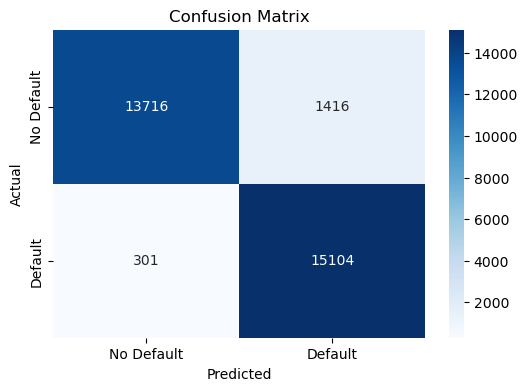

In [35]:
from sklearn.metrics import accuracy_score, f1_score

# Get predicted probabilities and labels
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]  # Probabilities for the positive class (default)
y_valid_pred = (y_valid_proba >= 0.5).astype(int)  # Convert probabilities to binary labels

# Compute evaluation metrics
auc = roc_auc_score(y_valid, y_valid_proba)
accuracy = accuracy_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

# Print results
print(f"AUC-ROC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Insights:

The model demonstrates high predictive accuracy in identifying credit card defaulters, achieving an

AUC-ROC score of 0.9845,

accuracy of 93.56%,

and an F1-score of 0.9383.

These metrics indicate that the model is effective in distinguishing defaulters from non-defaulters.

**Key Insights:**

**Strong Classification Ability:**

The high AUC-ROC score (0.9845) suggests the model has excellent discriminative power.

**Balanced Performance:**

Defaulters (Class 1) - Recall: 97% → The model correctly identifies most defaulters.

Non-defaulters (Class 0) - Precision: 97% → The model minimizes false positives, ensuring minimal misclassification of non-defaulters.

**Potential Improvements:**

Overfitting Check: Despite strong results, cross-validation is necessary to confirm generalizability to unseen data.

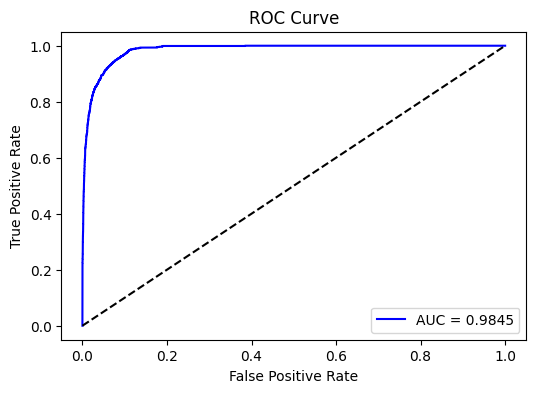

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_valid, y_valid_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Insights from ROC Curve:**

The AUC-ROC score of 0.9845 suggests that the model is highly effective at distinguishing between defaulters and non-defaulters.

The ROC curve being close to the top-left corner signifies an excellent balance between true positives and false positives.


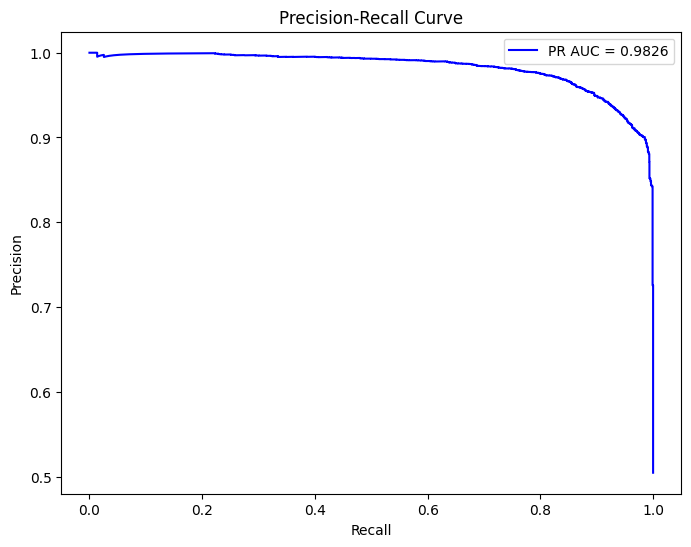

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Compute Precision-Recall values
precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba)

# Compute PR AUC score
pr_auc_score = auc(recall, precision)

# Plot PR Curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc_score:.4f}", color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


**Insights from Precision-Recall (PR) Curve**

The PR AUC score of 0.9826 indicates strong precision even when recall increases.

The curve remains close to high precision (>90%) across most recall values, confirming minimal false positives.

The sharp drop-off at the extreme right suggests performance degradation at very high recall values.



**Overall Conclusion**
The model achieves high predictive power with minimal misclassifications.

It is well-balanced but slightly favors recall (minimizing false negatives).


# Cheching for overfitting

In [ ]:
# Get training set predictions
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= 0.5).astype(int)

# Get validation set predictions
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

# Compute evaluation metrics for both sets
train_auc = roc_auc_score(y_train, y_train_proba)
valid_auc = roc_auc_score(y_valid, y_valid_proba)

train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

train_f1 = f1_score(y_train, y_train_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"Training AUC: {train_auc:.4f}, Validation AUC: {valid_auc:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}")
print(f"Training F1 Score: {train_f1:.4f}, Validation F1 Score: {valid_f1:.4f}")


Training AUC: 0.9875, Validation AUC: 0.9845
Training Accuracy: 0.9422, Validation Accuracy: 0.9356
Training F1 Score: 0.9437, Validation F1 Score: 0.9383


# Insight : The model is not overfitted as the difference between training and validation meterics are not large.

The final columns are stored in a submission.csv

In [ ]:
# Create submission dataframe
submission = pd.DataFrame({'account_number': test_data['account_number'], 'predicted_probability': test_preds})

# Save to CSV
submission.to_csv('submission.csv', index=False)

# Download the file
files.download("submission.csv")

print("Predictions saved to 'submission.csv'")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions saved to 'submission.csv'
